<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-Processing" data-toc-modified-id="Image-Processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image Processing</a></span></li><li><span><a href="#Keras-CNN" data-toc-modified-id="Keras-CNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Keras CNN</a></span></li><li><span><a href="#Gridsearch-Optimization" data-toc-modified-id="Gridsearch-Optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gridsearch Optimization</a></span></li><li><span><a href="#Final-Model" data-toc-modified-id="Final-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final Model</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#ROC-Curve-for-each-class" data-toc-modified-id="ROC-Curve-for-each-class-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>ROC Curve for each class</a></span></li><li><span><a href="#Sample-Images" data-toc-modified-id="Sample-Images-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Sample Images</a></span></li></ul></li><li><span><a href="#Evaluating-with-cvlib-gender-detection" data-toc-modified-id="Evaluating-with-cvlib-gender-detection-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluating with cvlib gender detection</a></span><ul class="toc-item"><li><span><a href="#Sample-Images" data-toc-modified-id="Sample-Images-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Sample Images</a></span></li></ul></li><li><span><a href="#Test-against-celeb-faces" data-toc-modified-id="Test-against-celeb-faces-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test against celeb faces</a></span><ul class="toc-item"><li><span><a href="#Sample-Images" data-toc-modified-id="Sample-Images-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Sample Images</a></span></li></ul></li></ul></div>

https://www.kaggle.com/sentdex/full-classification-example-with-convnet

In [1]:
import cv2
import cvlib as cv
import numpy as np
import pandas as pd
import os  
from random import shuffle
from IPython.display import display, Markdown
from tqdm import tqdm
import PIL
from PIL import Image
import seaborn as sn
from itertools import cycle

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from matplotlib.pyplot import imshow
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

sn.set()

df = pd.read_csv('data/individual_details.csv')

img_path = 'mugshots/mugs'
img_w = 120
img_h = 150
learning_rate = .001

Using TensorFlow backend.


# Image Processing

In [2]:
def label_img(img):
    booking_id = img.split('.')[0]
    
    sex = df[df['booking_number'] == booking_id].sex
    
    if sex.all() == 'MALE': return [1,0] 
    elif sex.all() == 'FEMALE': return [0,1]

    
def process_img(img_path):
    processed_data = []
    for img in tqdm(os.listdir(img_path)):
        label = label_img(img)
        path = os.path.join(img_path,img)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_w,img_h))
        processed_data.append([np.array(img),np.array(label)])
    shuffle(processed_data)
    return processed_data


# split data into train and test
def split_img(img, train=.8):
    length = len(img)
    cut_off = round(len(images)*train)
    
    return img[:cut_off], img[cut_off:]

In [3]:
images = process_img(img_path)

100%|█████████████████████████████████████████████████████████████████████████████| 2142/2142 [00:08<00:00, 249.10it/s]


# Keras CNN

In [4]:
train, test = split_img(images)

trainImages = np.array([i[0] for i in train]).reshape(-1, img_w, img_h, 3)
trainLabels = np.array([i[1] for i in train])

testImages = np.array([i[0] for i in test]).reshape(-1, img_w, img_h, 3)
testLabels = np.array([i[1] for i in test])

In [5]:
def create_model():

    model = Sequential()

    model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(img_w, img_h, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation = 'softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
    return model

# Gridsearch Optimization

In [6]:
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [40, 50, 60]
epochs = [40, 60, 80]
param_grid = dict(batch_size=batch_size, epochs=epochs)

In [7]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=5, verbose=1)
grid_result = grid.fit(trainImages, trainLabels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 43.9min finished


In [8]:
grid_result.best_params_

{'batch_size': 50, 'epochs': 80}

# Final Model

{'batch_size': 50, 'epochs': 80}

In [9]:
model = create_model()

btch = grid_result.best_params_['batch_size']
epch = grid_result.best_params_['epochs']

model.fit(trainImages, 
          trainLabels, 
          batch_size=btch, 
          epochs=epch, 
          validation_data = [testImages,testLabels],
#           callbacks=[early_stop],
          verbose=1)

Train on 1714 samples, validate on 428 samples
Epoch 1/80
1714/1714 [==============================] - 2s 1ms/step - loss: 0.3936 - accuracy: 0.8279 - val_loss: 0.4650 - val_accuracy: 0.8201
Epoch 2/80
1714/1714 [==============================] - 1s 753us/step - loss: 0.2896 - accuracy: 0.8786 - val_loss: 0.5457 - val_accuracy: 0.8271
Epoch 3/80
1714/1714 [==============================] - 1s 755us/step - loss: 0.2543 - accuracy: 0.9067 - val_loss: 0.7244 - val_accuracy: 0.7757
Epoch 4/80
1714/1714 [==============================] - 1s 751us/step - loss: 0.2034 - accuracy: 0.9207 - val_loss: 0.5487 - val_accuracy: 0.8388
Epoch 5/80
1714/1714 [==============================] - 1s 757us/step - loss: 0.1690 - accuracy: 0.9329 - val_loss: 0.9733 - val_accuracy: 0.7804
Epoch 6/80
1714/1714 [==============================] - 1s 756us/step - loss: 0.1756 - accuracy: 0.9277 - val_loss: 0.3967 - val_accuracy: 0.8855
Epoch 7/80
1714/1714 [==============================] - 1s 758us/step - loss: 0

# Model Evaluation

In [10]:
labels = []
pred_proba = []
predictions = []

for num,data in enumerate(test):
    
    img_num = data[1]
    img_data = data[0]
    
    data = img_data.reshape(-1,img_w,img_h,3)
    
    predict = model.predict([data])[0]
    
    if np.argmax(predict) == 0: 
        predictions.append(1)
        pred_proba.append(predict[0])
    elif np.argmax(predict) == 1: 
        predictions.append(0)
        pred_proba.append(predict[1])
        
    if img_num[0] == 1: labels.append(1)
    else: labels.append(0)

acc = accuracy_score(labels, predictions)
fpr, tpr, threshold = roc_curve(labels, pred_proba)  # Values for ROC curve
roc_auc = auc(fpr, tpr)
prec = precision_score(labels, predictions)
rec = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

# Results For Epoch Model

### Overall Accuracy :<span style="color:red"> 0.907</span>

Precision: 0.917 | Recall: 0.963 | F1 Score: 0.94


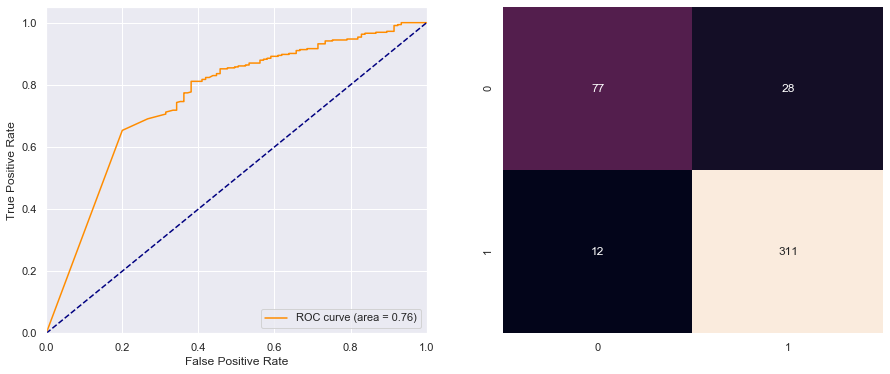

In [11]:
display(Markdown(f'# Results For Epoch Model'))
display(
    Markdown(
        '### Overall Accuracy :<span style="color:red"> %.3g</span>' %
        (acc)))
print("Precision: %.3g | Recall: %.3g | F1 Score: %.3g" %
      (prec, rec, f1))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.subplot(1,2,2)
conf = confusion_matrix(labels, predictions)
sn.heatmap(conf, annot=True, fmt="d", cbar=False)
plt.show()

## ROC Curve for each class

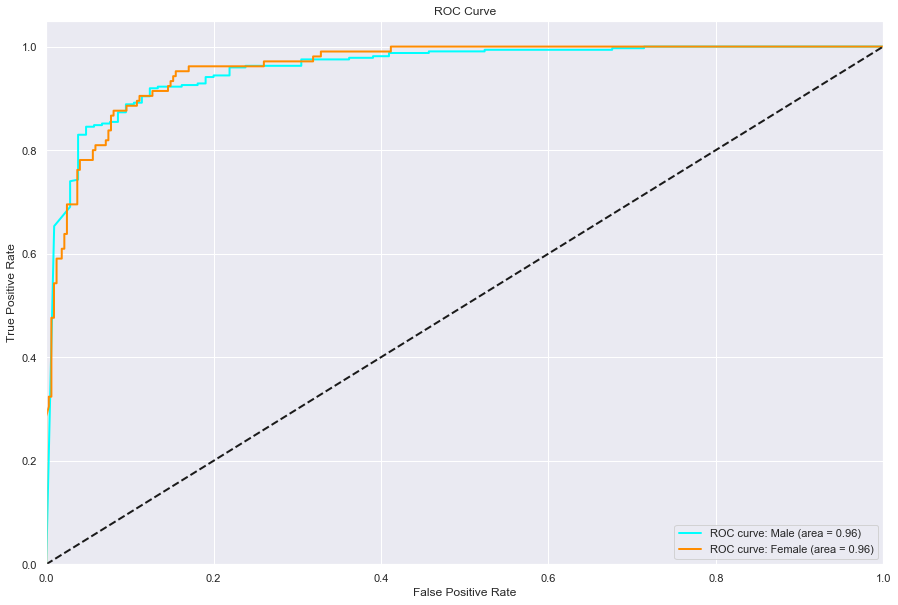

In [12]:
n_classes = 2

y_pred_keras = model.predict(testImages)

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testLabels[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure(figsize=(15,10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
labels = ['Male', 'Female']

for i, color, l in zip(range(n_classes), colors, labels):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0} (area = {1:0.2f})'
             ''.format(l, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Sample Images

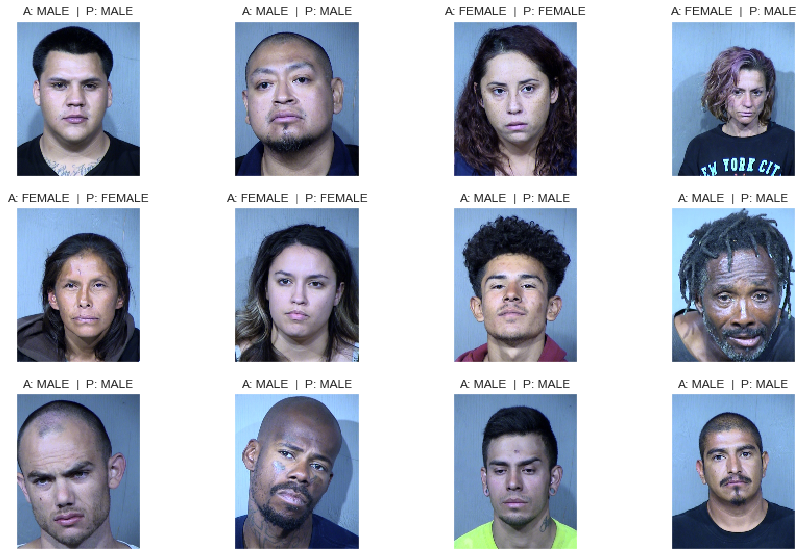

In [13]:
fig=plt.figure(figsize=(15, 20))

for num,data in enumerate(images[-12:]):
 
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(6,4,num+1)
    orig = img_data
    data = img_data.reshape(-1, img_w, img_h, 3)

    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 0: str_label='MALE'
    elif np.argmax(model_out) == 1: str_label='FEMALE'
    else: str_label='None'
    
    if img_num[0] == 1: actual = 'MALE'
    else: actual = 'FEMALE'
        
    y.imshow(orig)
    plt.title(f'A: {actual}  |  P: {str_label}')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()

# Evaluating with cvlib gender detection

In [14]:
labels = []
pred_proba = []
predictions = []

for num,data in enumerate(test):
    
    img_num = data[1]
    img_data = data[0]

    _, predict = cv.detect_gender(img_data)
    
    if np.argmax(predict) == 0: 
        predictions.append(1)
        pred_proba.append(predict[0])
    elif np.argmax(predict) == 1: 
        predictions.append(0)
        pred_proba.append(predict[1])
        
    if img_num[0] == 1: labels.append(1)
    else: labels.append(0)

acc = accuracy_score(labels, predictions)
fpr, tpr, threshold = roc_curve(labels, pred_proba)  # Values for ROC curve
roc_auc = auc(fpr, tpr)
prec = precision_score(labels, predictions)
rec = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

[INFO] Initializing gender detection model ..


# Results For Epoch Model

### Overall Accuracy :<span style="color:red"> 0.731</span>

Precision: 0.871 | Recall: 0.755 | F1 Score: 0.809


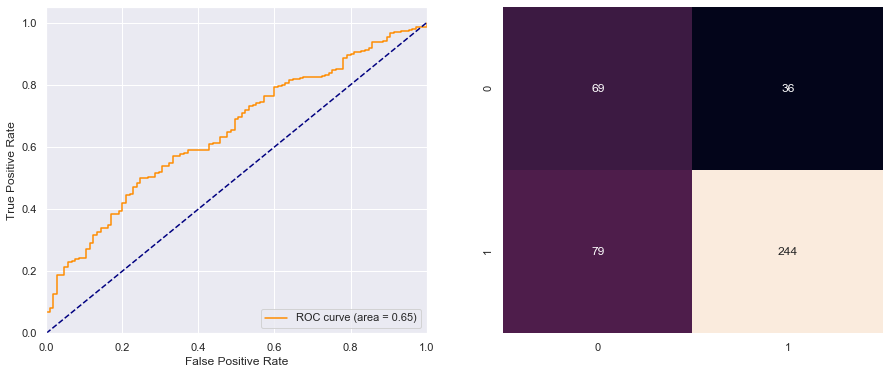

In [15]:
display(Markdown(f'# Results For Epoch Model'))
display(
    Markdown(
        '### Overall Accuracy :<span style="color:red"> %.3g</span>' %
        (acc)))
print("Precision: %.3g | Recall: %.3g | F1 Score: %.3g" %
      (prec, rec, f1))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.subplot(1,2,2)
conf = confusion_matrix(labels, predictions)
sn.heatmap(conf, annot=True, fmt="d", cbar=False)
plt.show()

## Sample Images

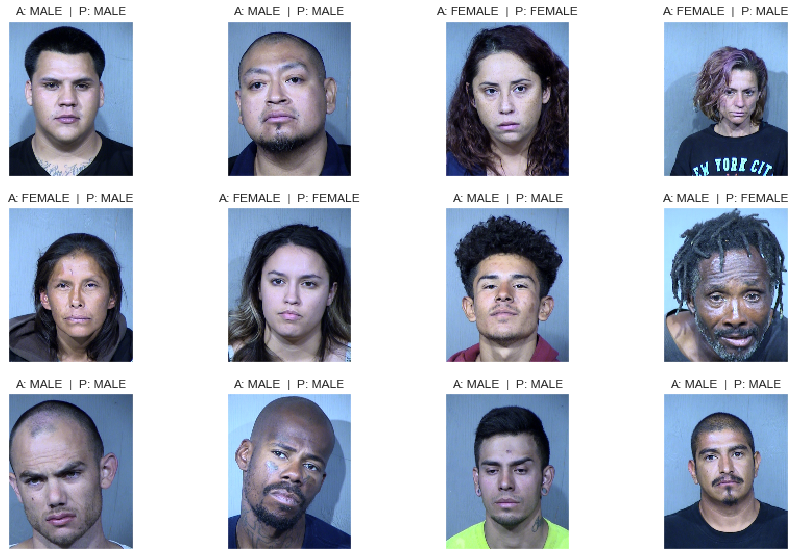

In [16]:
fig=plt.figure(figsize=(15, 20))

for num,data in enumerate(images[-12:]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(6,4,num+1)
    orig = img_data
    data = img_data.reshape(-1, img_w, img_h, 3)

#     model_out = model.predict([data])[0]
    
    _, model_out = cv.detect_gender(img_data)
    
    if np.argmax(model_out) == 0: str_label='MALE'
    elif np.argmax(model_out) == 1: str_label='FEMALE'
    else: str_label='None'
    
    if img_num[0] == 1: actual = 'MALE'
    else: actual = 'FEMALE'
        
    y.imshow(orig)
    plt.title(f'A: {actual}  |  P: {str_label}')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()

# Test against celeb faces

In [17]:
def label_img(img):

    sex = celeb_df[celeb_df['id'] == img].Male
    
    if sex.any() == 1: return [1,0] 
    
    elif sex.any() == 0: return [0,1]

In [18]:
celeb_df = pd.read_csv('data/celeb_sample.csv')

celeb_img_path = 'mugshots/celeb_sample/'

In [19]:
celeb_images = process_img(celeb_img_path)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 880.28it/s]


In [20]:
testImages = np.array([i[0] for i in celeb_images]).reshape(-1, img_w, img_h, 3)
testLabels = np.array([i[1] for i in celeb_images])

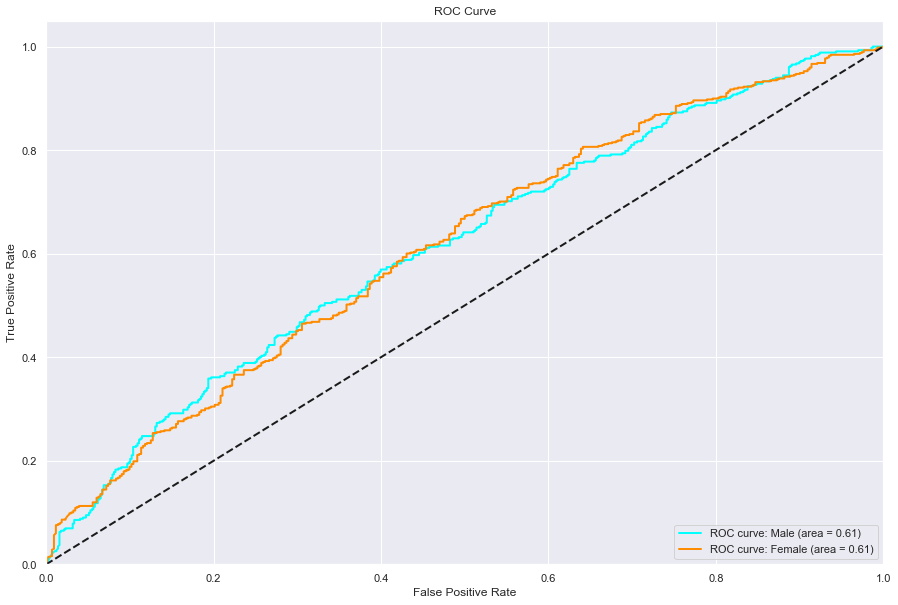

In [21]:
n_classes = 2

y_pred_keras = model.predict(testImages)

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testLabels[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure(figsize=(15,10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
labels = ['Male', 'Female']

for i, color, l in zip(range(n_classes), colors, labels):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0} (area = {1:0.2f})'
             ''.format(l, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Sample Images

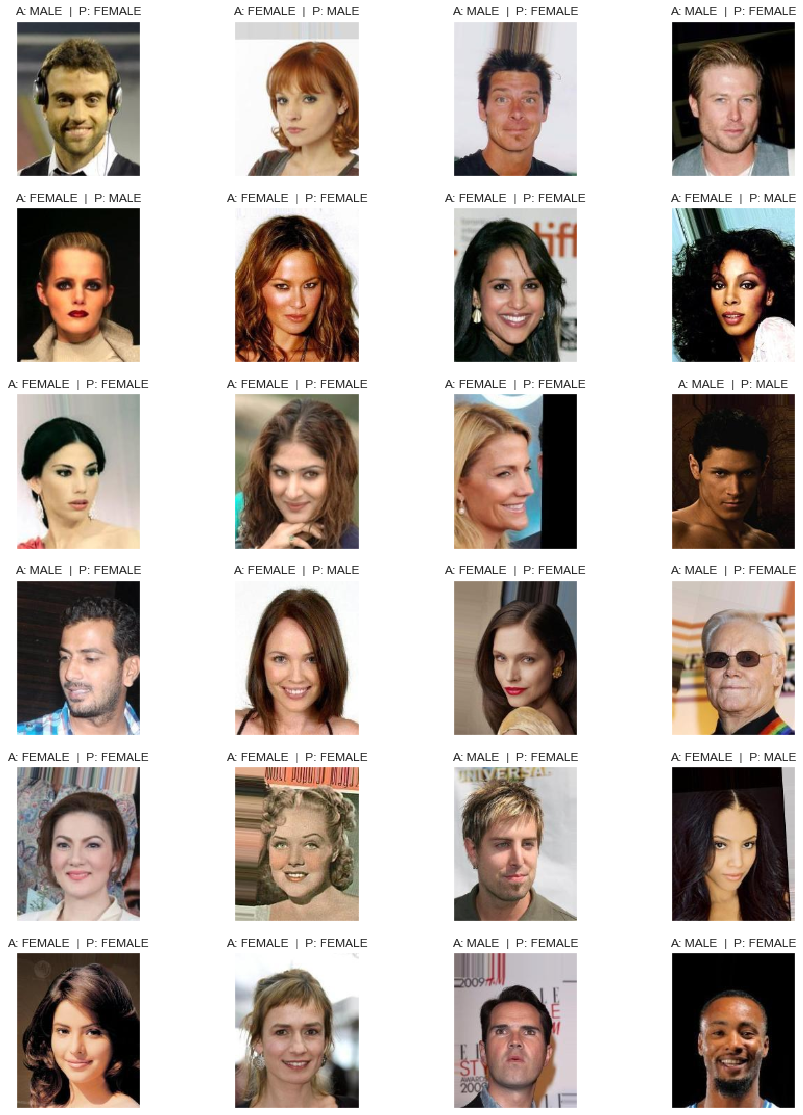

In [22]:
fig=plt.figure(figsize=(15, 20))

for num,data in enumerate(celeb_images[-24:]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(6,4,num+1)
    orig = img_data
    data = img_data.reshape(-1, img_w, img_h, 3)

    model_out = model.predict([data])[0]
    
    
    if np.argmax(model_out) == 0: str_label='MALE'
    elif np.argmax(model_out) == 1: str_label='FEMALE'
    else: str_label='None'
    
    if img_num[0] == 1: actual = 'MALE'
    else: actual = 'FEMALE'
        
    y.imshow(orig)
    plt.title(f'A: {actual}  |  P: {str_label}')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()